Introduction:

Why do we need recommender systems?
All entertainment websites or online stores have millions/billions of items. It becomes challenging for the customer to select the right one. At this place, recommender systems come into the picture and help the user to find the right item by minimizing the options.

What are recommender systems?
It helps the user to select the right item by suggesting a presumable list of items and so it has become an integral part of e-commerce, movie and music rendering sites and the list goes on. They are becoming one of the most popular applications of machine learning which has gained importance in recent years. The two most popular ways it can be approached/built are:

1- Content-based recommendations .

2- Collaborative FIltering .

In this , we will be focussing on the Collaborative filtering method that is: the user is recommended items that people with similar tastes and preferences liked in the past.

We will be working with MovieLens Dataset, a movie rating dataset, to develop a recommendation system using the surprise library.

In [1]:
!pip install surprise
import os
import pandas as pd
import numpy as np
from surprise import Reader

from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
#from surprise import SlopeOne
#from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

     |████████████████████████████████| 11.8MB 7.1MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617518 sha256=cf2e082d419baa4a2dbe3076c802b3152744a2a5ad6e118e8f1a6013c333e96a
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
df.shape

(100836, 3)

To load a data set from the above pandas data frame, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified.

The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order.

In [4]:
# Define the format
reader = Reader(line_format='user item rating timestamp', sep='\t')

reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# Split data into 5 folds

#data.split(n_folds=5)

In [6]:
import pandas as pd

ratings = pd.read_csv('ratings.csv')
ratings.head()
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)

df.groupby('itemID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,itemID,rating
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
224,260,251
418,480,238
97,110,237
507,589,224
461,527,220


In [7]:
df.groupby('userID')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userID,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
609,610,1302
67,68,1260
379,380,1218
605,606,1115
287,288,1055


The minimumn number of ratings given by a user is 20, where as the most productive user is user-413 giving 2698 rating. The data is properly distributed and the big chunk of ratings is between 3 and 5 which means people are not very hard but towards rating

Surprise - Model Selection

Surprise is a Python scikit building and analyzing recommender systems that deal with explicit rating data. Maintained by Nicolas Hug.

In [8]:
!pip install numpy
!pip install scikit-surprise

Here are the average RMSE, MAE and total execution time of various algorithms (with their default parameters) on a 3-fold cross-validation procedure.

We will use RMSE as our accuracy metric for the predictions.

We will be comparing SVD, NMF, Normal Predictor, KNN Basic and will be using the one which will have least RMSE value.

Some understanding on the algorithms before we start applying.

1: Normal Predictor: It predicts a random rating based on the distribution of the training set, which is assumed to be normal. It's a basic algorithm that does not do much work but that is still useful for comparing accuracies.

2: SVD: It got popularized by Simon Funk during the Netflix prize and is a Matrix Factorized algorithm. If baselines are not used, it is equivalent to PMF.

3: NMF: It is based on Non-negative matrix factorization and is similar to SVD.

4: KNN Basic: This is a basic collaborative filtering algorithm method.

In [9]:
from surprise import reader
reader = Reader(line_format='user item rating timestamp', sep='\t')

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), NormalPredictor(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]],index=['Algorithm']))
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [10]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.880625,4.231846,0.330713
NMF,0.933356,5.698862,0.300491
KNNBasic,0.959603,0.114554,2.438764
NormalPredictor,1.424757,0.129307,0.317383


Tuning algorithm parameters with GridSearchCV to find the best parameters for the algorithm.

Default values for svd( ):

n_factors - 100

n_epochs - 20

lr_all – 0.005

reg_all – 0.02

In [ ]:
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


Training and Testing


In [ ]:
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)
#predictions

RMSE: 0.8779


0.8779056548642059

Let's check how good or bad our predictions are:

The following function will create a pandas data frame which will consist of these columns:

UID: user-id

iid: item id

Rui: the rating given by the user

est: rating estimated by the model

Iu: No of items rated by the user

UI: number of users that have rated this item

err: abs difference between predicted rating and the actual rating.

In [ ]:

#predictions
def get_Iu(uid):
    """ 
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ 
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,387,2139,4.0,3.400702,{'was_impossible': False},787,15,0.599298
1,526,3448,5.0,4.220681,{'was_impossible': False},46,33,0.779319
2,450,1580,3.0,3.819292,{'was_impossible': False},35,118,0.819292
3,45,4734,5.0,3.436171,{'was_impossible': False},308,27,1.563829
4,51,1645,5.0,3.292316,{'was_impossible': False},280,35,1.707684


Let's see the 10 best and worst predictions our model made

In [ ]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1325,475,1210,5.0,5.0,{'was_impossible': False},113,146,0.0
18982,25,5952,5.0,5.0,{'was_impossible': False},17,131,0.0
7043,348,50,5.0,5.0,{'was_impossible': False},40,156,0.0
4963,452,1221,5.0,5.0,{'was_impossible': False},142,94,0.0
3946,597,260,5.0,5.0,{'was_impossible': False},335,188,0.0
14154,122,1136,5.0,5.0,{'was_impossible': False},222,107,0.0
23654,30,1198,5.0,5.0,{'was_impossible': False},27,150,0.0
10666,106,318,5.0,5.0,{'was_impossible': False},26,233,0.0
22458,122,608,5.0,5.0,{'was_impossible': False},222,133,0.0
9136,452,1089,5.0,5.0,{'was_impossible': False},142,96,0.0


In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
5754,182,7153,1.0,4.621940,{'was_impossible': False},692,143,3.621940
19010,111,593,0.5,4.132474,{'was_impossible': False},498,205,3.632474
20428,154,86644,0.5,4.200164,{'was_impossible': False},26,6,3.700164
19876,542,1732,0.5,4.260783,{'was_impossible': False},83,82,3.760783
19490,426,47,0.5,4.284836,{'was_impossible': False},53,148,3.784836
11965,580,1250,0.5,4.298141,{'was_impossible': False},332,33,3.798141
13456,580,1207,0.5,4.301877,{'was_impossible': False},332,41,3.801877
19979,105,4027,0.5,4.357468,{'was_impossible': False},555,74,3.857468
20582,256,5618,0.5,4.548539,{'was_impossible': False},124,69,4.048539
13965,543,89904,0.5,4.954417,{'was_impossible': False},55,7,4.454417


The worst predictions look pretty surprise. Let's look in more details of item "3996", rated 0.5, our SVD algorithm predicts 4.4

In [ ]:
df.loc[df['itemID'] == 3996]['rating'].describe()

count    110.000000
mean       3.836364
std        1.031853
min        0.500000
25%        3.500000
50%        4.000000
75%        4.500000
max        5.000000
Name: rating, dtype: float64

K Recommendations

Recall and precision at K

Recall and precision are the classical evaluation metric and are used to evaluate the binary metric and so we have to convert our rating which is scaled from (1-5) into a binary problem relevant and not relevant items.

Conversion to binary
To do the translation we have to select an arbitrary value on which we can say any rating above that will be considered relevant. There are many methods on selecting that value but for now, we will select 3.5 as the threshold, which means any true rating above 3.5 will be considered relevant and below will be not relevant.


Deciding 'k'
In recommendation systems, we are interested in showing the top N items to users and so the best is to compute precision and recall on top N values instead of calculating on all the items.

Definition of Relevant and Recommended

Relevant: True Rating > = 3.5

Irrelevant: True Rating < 3.5

Recommended item: Predicted Rating > = 3.5

Not Recommended item: Predicted Rating <  3.5

Definition of Precision and Recall
Precision: It tries to answer "What proportion of positive identifications was actually correct?" i.e True positive / (True positive+False Positive) in RecSys we can say (# of recommended items @k that are relevant) / (# of recommended items @k)

Recall: It tries to answer "What proportion of actual positives were identified correctly?" i.e True positive / (True Positive+False Negative) in RecSys we can say (# of recommended items @k that are relevant) / (# of relevant items @k)

While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.

In some circumstances, we might know that we need to maximize either recall or precision at the cost of the other metric. For example, in disease screening of patients, we would probably want a recall near 1.0 i.e. we want to find all patients who have the disease.

However, in cases where we want to obtain an optimal blend of precision and recall, we can use F1 score which is the harmonic mean of precision and recall taking both metrics into account while calculating it.

f1 score = 2 * (precision * recall) / (precision + recall)

The below function computes precision and recall and F1 socre as explained above.

In [ ]:

#Calculate TP,FP,TN,FN at every threshold level (0.0 - 5.0)

final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0
  fn=0
  fp=0
  tn=0
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,25209,0,0,0,1.000000,1.000000,1.000000
1,0.5,25209,0,0,0,1.000000,1.000000,1.000000
2,1.0,24861,348,0,0,0.986195,1.000000,0.993050
3,1.5,24149,1042,10,8,0.958636,0.999669,0.978723
4,2.0,23586,1406,115,102,0.943742,0.995694,0.969022
5,2.5,21138,2764,719,588,0.884361,0.972936,0.926536
6,3.0,18003,2510,2361,2335,0.877639,0.885190,0.881398
7,3.5,10532,2687,7149,4841,0.796732,0.685097,0.736710
8,4.0,4017,936,12271,7985,0.811024,0.334694,0.473843
9,4.5,580,261,19598,4770,0.689655,0.108411,0.187369


As per the results above, the optimal value for threshold is 2.5.

The next step is to find the optimal K value, and to find it we have to first calculate precision and recall for all the K values(2-10) having threshold value 2.5.

Below is the function to calculate precision and recall @ K.

In [ ]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls
    
    
###


In [ ]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results

###


[{'K': 2, 'Precision': 0.9360655737704918, 'Recall': 0.16562978482693408},
 {'K': 3, 'Precision': 0.9314207650273227, 'Recall': 0.23806092191465944},
 {'K': 4, 'Precision': 0.9289617486338799, 'Recall': 0.3088923237254418},
 {'K': 5, 'Precision': 0.9276502732240448, 'Recall': 0.37188704345632495},
 {'K': 6, 'Precision': 0.926284153005465, 'Recall': 0.4279995295544372},
 {'K': 7, 'Precision': 0.9242544886807177, 'Recall': 0.47634588881442097},
 {'K': 8, 'Precision': 0.9209465261514447, 'Recall': 0.5148185275682418},
 {'K': 9, 'Precision': 0.9213791308873294, 'Recall': 0.5495873968413615},
 {'K': 10, 'Precision': 0.9213427010148323, 'Recall': 0.5804897189999692}]

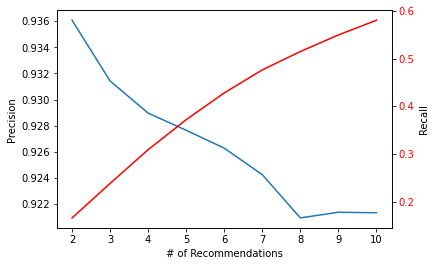

In [ ]:
Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')
    ###

As the graph states, Precision drops significantly when K=4

So we will consider the value of K to be 4.

Time to recommend some movies to users

Now as we know the optimal number of recommendations to provide, it's time to give recommendations to users. To do so we have to predict ratings for the movies which user has not yet watched.

Here we will be using build_anti_testset() method to get the data for testset as we have to predict ratings for the (user, item) pairs which are not present.

In [ ]:
#data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD()
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

Below is the function to get all the prediction sorted.

In [ ]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

In [ ]:
all_pred = get_all_predictions(predictions)


As we have all the predicted rating, We'll subset to only top K movies for every user, where K is 4

In [ ]:
#To get top 4 reommendation
n = 4

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]


In [ ]:
tmp = pd.DataFrame.from_dict(all_pred)


In [ ]:
tmp_transpose = tmp.transpose()

Now we have a dataframe which consits of top 4 movies recommended to every user.
Let's try one example and find recommendations for user 67

In [ ]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [ ]:
user_id=67
results = get_predictions(user_id)
results

0    (1104, 4.519744913736044)
1    (3275, 4.467091996013926)
2      (50, 4.450919983416349)
3    (2160, 4.443072084810857)
Name: 67, dtype: object

Above matrix is showing top "4" recommendations for user 67. (Movie-id, Predicted-Rating).

But we just need the movies not the ratings, so let's extract the movie id's from the result.

In [ ]:
recommended_movie_ids=[]
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids

[1104, 3275, 50, 2160]

Now as we have the movie-id's to be recommended, Let's find out the movie details of those id's by reading the movie data

In [ ]:
movies = pd.read_csv('movies.csv')
movies.head()
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
recommended_movies

,movieId,title,genres
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
841,1104,"Streetcar Named Desire, A (1951)",Drama
1616,2160,Rosemary's Baby (1968),Drama|Horror|Thriller
2462,3275,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller


Lets check the user history to see wether the given recommendations are similar or not

In [ ]:
ratings = pd.read_csv('ratings.csv')


ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
                

df = pd.DataFrame(ratings_dict)
df.head()

,itemID,userID,rating
0,1,1,4.0
1,3,1,4.0
2,6,1,4.0
3,47,1,5.0
4,50,1,5.0


In [ ]:
temp = df[df['userID'] == 67].sort_values("rating", ascending = False)
temp.head()


,itemID,userID,rating
10324,293,67,5.0
10352,8604,67,5.0
10332,1527,67,5.0
10354,27193,67,5.0
10343,4886,67,4.5


In [ ]:
temp.shape

(36, 3)

User 67 has rated 36 movies

In [ ]:
history_movie_ids = temp['itemID']
user_history = movies[movies['movieId'].isin(history_movie_ids)]

In [ ]:
user_history[:n]

,movieId,title,genres
254,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War


Now we can compare the results with the user history and see how relevant the recommendations are.

Above is the user history and below the recommended movies

In [ ]:
recommended_movies

,movieId,title,genres
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
841,1104,"Streetcar Named Desire, A (1951)",Drama
1616,2160,Rosemary's Baby (1968),Drama|Horror|Thriller
2462,3275,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller


As the history of the user tells that the user mostly likes movies that are mixed that means he prefer crime,thriller,drama,comedy and we are recommending  movies that are crime,thriller,drama beacuase those are highly preferred by user, which means we are recommending the right movies to the user.